In [2]:
import numpy as np
from matplotlib import pyplot as plt
import time
import diffusionstuff6 as ds
from copy import copy as dup
from scipy.integrate import odeint
%matplotlib notebook

In [6]:
# All the parameters

lastfile = 'NeshData/ode03_500_50.npz'; Load_old_file = True
nextfile = 'NeshData/ode04_500_50.npz'; Save_new_file = True
trajfile = 'NeshData/traj.npz'; trajflag = True

# Number of iterations to calculate Nliq from Ntot
niter = 1

# Loading/initializing state
if not Load_old_file:

    # Message
    print "Starting a new system"
    nx = 500 # Number of points in simulation box
    xmax = 50
    x = np.linspace(0, xmax, nx)
    boxpoints = len(x)
    deltaX = x[1]-x[0]
    Nbar = 1.0 # new Nbar from VMD, 260K
    Nstar = .9/(2*np.pi)

    # Initialize as a pre-equilibrated layer of liquid over ice
    Nice = np.zeros(boxpoints)+1
    Fliq = ds.getNliq(Nice,Nstar,Nbar,niter)

else:
    
    # Message
    print "loading", lastfile
    npzfile = np.load(lastfile)
    Fliq = npzfile['Fliq']
    Nice = npzfile['Nice']
    Nbar = npzfile['Nbar']
    Nstar = npzfile['Nstar']
    x = npzfile['x']
    boxpoints = len(x)
    nx = len(x)
    deltaX = x[1]-x[0]
    
# Lay out the system
Ntot = Fliq + Nice
nmid = int(nx/2)
xmid = max(x)/2
xmax = x[nx-1]
Nice_start = Nice[0]
Niceoffset = ds.getNiceoffset(Nbar, Nstar, 1, 0) # Should be close to .75; not used if D=const

# Just conversions
nmpermonolayer = 0.3
umpersec_over_mlyperus = (nmpermonolayer/1e3*1e6)

# Diffusion coefficient
D = 0.02e-2 # micrometers^2/microseconds

# Time steps
dtmaxtimefactor = 10
dtmax = deltaX**2/D
deltaT = dtmax/dtmaxtimefactor

# Deposition rate
nu_kin = 49 # microns/second
deprate = nu_kin/umpersec_over_mlyperus # monolayers per microsecond
deprate_times_deltaT = deprate * deltaT

# Supersaturation
sigma0 = 0.19
sigmastepmax = 0.20 # Must be bigger than sigma0 to get growth
center_reduction = 0.25 # In percent
sigmapfac = 1-center_reduction/100

# Diffusion coefficient scaled for this time-step and space-step
DoverdeltaX2 = D/deltaX**2

# Flag for explicit updating Fliq(Ntot) every step
updatingFliq = True

# Gets the function sigma(x)
fsig = (np.cos(x/xmax*np.pi*2)+1)/2*(1-sigmapfac)+sigmapfac
sigmastep = sigmastepmax*fsig
# Same as:
# sigmastepmin = sigmapfac*sigmastepmax
# sigmastep = (np.cos(x/xmax*np.pi*2)+1)/2*(sigmastepmax-sigmastepmin)+sigmastepmin

# Set up a maximum number of iterations 
countermax_0D = 500

# Set up a maximum number of iterations for the 1D run 
countermax_1D = 500

loading NeshData/ode03_500_50.npz


In [3]:
# Reporting
print "D =", D, 'um^2/us',D * 1e-12*1e6*1e9, 'x 10^-9 m^2/sec'
print 'deltaT_max (Diffusion time)', dtmax
print 'deltaT =', deltaT
print 'deprate =', deprate, 'monolayers/us'
print 'nmid', nmid
print 'N*', Nstar
print 'N*x2pi', Nstar*2*np.pi
print 'Nbar, Nbar-N*, N*/Nbar', Nbar, Nbar-Nstar, Nstar/Nbar
print 'deltaX', deltaX
print 'sigma_0 =', sigma0
print 'sigmastepmax =', sigmastepmax
print 'center reduction, %', center_reduction
print 'sigmapfac =', sigmapfac
print 'max growth rate =', deprate*sigmastepmax*umpersec_over_mlyperus, 'um/sec'
print 'min growth rate =', deprate*(sigmastepmax-sigma0)*umpersec_over_mlyperus, 'um/sec'
print 'nu_kin =', nu_kin, 'um/sec'

D = 0.0002 um^2/us 0.2 x 10^-9 m^2/sec
deltaT_max (Diffusion time) 50.200601604
deltaT = 5.0200601604
deprate = 0.163333333333 monolayers/us
nmid 250
N* 0.143239448783
N*x2pi 0.9
Nbar, Nbar-N*, N*/Nbar 1.0 0.856760551217 0.143239448783
deltaX 0.100200400802
sigma_0 = 0.19
sigmastepmax = 0.2
center reduction, % 0.25
sigmapfac = 0.9975
max growth rate = 9.8 um/sec
min growth rate = 0.49 um/sec
nu_kin = 49 um/sec


<IPython.core.display.Javascript object>


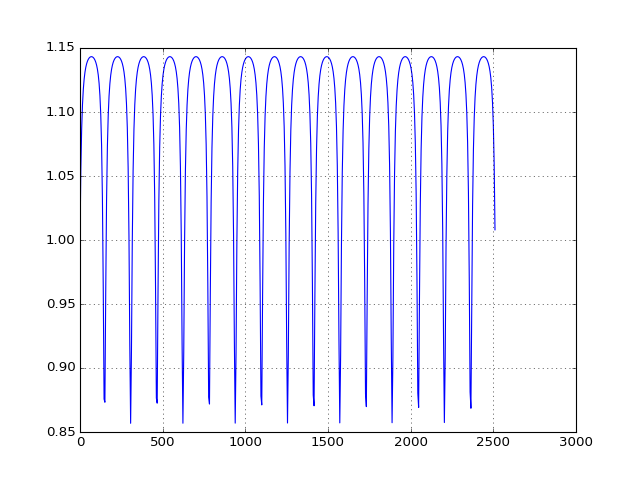

0-D Modeled growth rate, um/s 1.73103730136
0-D Modeled alpha 0.176636459323


In [4]:
# This is the 0-d run

# Bundle parameters for ODE solver
params = [Nbar, Nstar, niter, sigmastepmax, sigma0, deprate]

# Initial conditions for ODE solver
y0 = [Nbar, 0.0]
ylast = dup(y0)

# Time steps
t0 = 0.0
ttot = 0.0
tinterval = [t0, deltaT]

# Initialize the keeper arrays
tkeep = [t0]
ykeep = [y0]
tlast = dup(t0)
Nicelast0 = 0.0
Nicelast_start = 0.0

# Call the ODE solver
counter = 0
while counter < countermax_0D:
    
    # Integrate up to next time step
    y = odeint(ds.f0d, ylast, tinterval, args=(params,))
    ylast = list(y[1,:])
    tlast += deltaT
    counter += 1
    
    # Stuff into keeper arrays
    ykeep.append(ylast)
    tkeep.append(tlast)
    
    # Make some local copies, with possible updates to Fliq
    Fliqlast, Ntotlast = ylast
    if updatingFliq:
        Fliqlast = ds.getNliq(Ntotlast,Nstar,Nbar,niter) # This updates Fliqlast and ylast!
        ykeep[counter][0] = Fliqlast # Saves the updated Fliq for this step
    Nicelast = Ntotlast - Fliqlast
    Nicelast0 = dup(Nicelast)
    
# Convert results to a numpy array
ykeeparr = np.array(ykeep, np.float64)

# Plot results
plt.figure(1)
plt.plot(tkeep,ykeeparr[:,0])
plt.grid('on')

# Growth statistics
delta_Nice_0d = Nicelast0-Nicelast_start
growthrate_0d = delta_Nice_0d/tlast*umpersec_over_mlyperus
print  "0-D Modeled growth rate, um/s", growthrate_0d
alpha_0d = growthrate_0d/nu_kin/sigmastepmax
print  "0-D Modeled alpha", alpha_0d

In [5]:
# This is the 1-d run

# Timing
sec1 = time.time()

# Bundle parameters for ODE solver
params = [Nbar, Nstar, niter, sigmastep, sigma0, deprate, DoverdeltaX2, nx]

# Initial conditions for ODE solver
y0 = list((Fliq,Ntot))
ylast = dup(y0)

# Time steps
t0 = 0.0
tlast = dup(t0)
ttot = 0.0
tinterval = [t0, deltaT]

# Initialize the keeper arrays
tkeep = [t0]
Nicekeep = [Nice]
Fliqkeep = [Fliq]

# Call the ODE solver
Nice0_start = Nice[0]
Nice0 = Nice[0]
updatingFliq = True
counter = 0
while counter < countermax_1D:
    
    # Integrate up to next time step
    y = odeint(ds.f1d, np.reshape(ylast,2*nx), tinterval, args=(params,))
    ylast = np.reshape(y[1],(2,nx))
    tlast += deltaT
    counter += 1
        
    # Make some local copies, with possible updates to Fliq
    Fliq, Ntot = ylast
    if updatingFliq:
        Fliq = ds.getNliq(Ntot,Nstar,Nbar,niter) # This updates to remove any drift
        ylast[0] = Fliq
    Nice = Ntot - Fliq
    Nice0 = Nice[0]
    ttot += deltaT
    
    # Stuff into keeper arrays if requested
    if trajflag:
        Nicekeep.append(Nice)
        Fliqkeep.append(Fliq)
        tkeep.append(ttot)

Height of Ice 84.0939263536


<IPython.core.display.Javascript object>


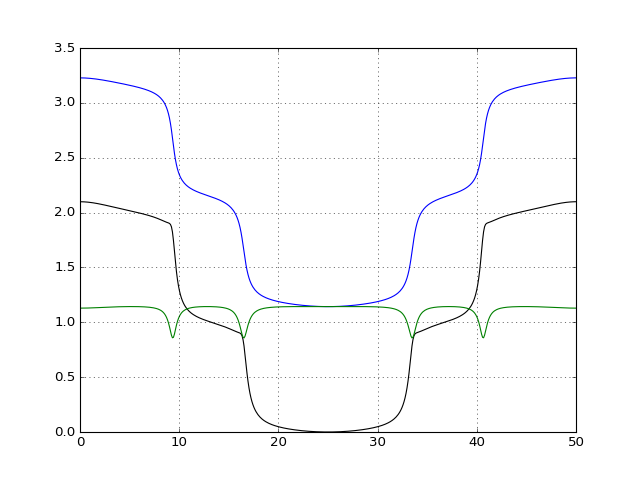

1-D growth 15.8466304866
1-D Modeled growth rate, um/s 1.89399688214
1-D Modeled alpha 0.193264987974
0-D Modeled growth rate, um/s 1.73103730136
0-D Modeled alpha 0.176636459323
Growth ratio 1D/0D 1.09413984358
Libbrecht's predicted growth rate, um/s 1.83935820632
Libbrecht's predicted alpha 0.18768961289
Time taken: 0 min 48.9218790531 secs


In [6]:
# Plot
minpoint = min(Nice)
print"Height of Ice", minpoint
plt.figure(3)
plt.plot(\
         x, Nice-minpoint, 'k', \
         x, Fliq+Nice-minpoint, 'b', \
         x, Fliq, 'g')
plt.grid('on')

# Growth statistics
delta_Nice = Nice[0]-Nice_start
print  "1-D growth", delta_Nice
growthrate = delta_Nice/ttot*umpersec_over_mlyperus
print  "1-D Modeled growth rate, um/s", growthrate
alpha = growthrate/nu_kin/sigmastepmax
print  "1-D Modeled alpha", alpha

# Comparisons with 0-D model
print  "0-D Modeled growth rate, um/s", growthrate_0d
print  "0-D Modeled alpha", alpha_0d
print  "Growth ratio 1D/0D", growthrate/growthrate_0d

# Comparisons with Libbrecht
sigma0_L = 0.08
A_L = .28
alpha_L = A_L*np.exp(-sigma0_L/sigmastepmax)
print "Libbrecht's predicted growth rate, um/s", nu_kin*alpha_L*sigmastepmax
print "Libbrecht's predicted alpha", alpha_L

# Timing statistics
sec2 = time.time()
print "Time taken:", int((sec2-sec1)/60), "min", (sec2-sec1)%60, "secs"

In [7]:
# Saving these results to file
print Nice[0]
if Nice[0] > 100000:
    Nice -= 100000
if Save_new_file:
    print "saving to", nextfile
    np.savez_compressed(nextfile, Nice=Nice,
                        Fliq=Fliq, Nbar=Nbar, Nstar=Nstar,
                        x=x, t=ttot)

86.1927578213
saving to NeshData/ode04_500_50.npz


In [8]:
if trajflag:
    print "saving to", trajfile
    np.savez_compressed(trajfile, Nice=Nicekeep,
                        Fliq=Fliqkeep,
                        x=x, t=tkeep)

saving to NeshData/traj.npz
